# RNN 실습

이번 실습에서는 RNN을 사용하여 주어진 영화 리뷰의 감정 분석 모델을 구현하고 학습할 것 입니다. 우선 필요한 library들 부터 import합니다.

In [1]:
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
from datasets import load_dataset

C:\Users\rlgus\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## IMDB dataset

이번에는 영화 리뷰 감정 분석을 위한 dataset인 IMDB를 불러옵니다.
Huggingface에서 제공하는 `load_dataset` 함수를 사용하여 다음과 같이 불러올 수 있습니다.

In [3]:
ds = load_dataset("stanfordnlp/imdb")
ds

C:\Users\rlgus\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rlgus\.cache\huggingface\hub\datasets--stanfordnlp--imdb. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating unsupervised split: 100%|██████████| 50000/50000 [00:00<00:00, 708093.01 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

이외에도 다양한 dataset들을 다운받을 수 있습니다. 다음 링크에서 dataset 목록을 확인할 수 있습니다: https://huggingface.co/datasets.

이번에는 data 형태를 확인하기 위해 train data의 첫 번째 data를 한 번 확인해봅시다.

In [4]:
ds['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

보시다시피 각각의 data는 text와 긍정적인지 부정적인지 의미하는 label로 구성되어있습니다.
여기서 label은 0 또는 1의 값을 가집니다.

## Tokenizer 제작

이번에는 tokenizer를 huggingface library를 활용하여 직접 만들어 볼 것입니다.
다음과 같이 필요한 library들을 import하고 tokenizer model을 만듭니다.

In [5]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

이번에는 WordPiece를 사용할 것 입니다.
WordPiece 이외의 모델들도 많이 있습니다. 이전 챕터에서 배운 BPE 또한 지원을 하고 있습니다.
지원하고 있는 tokenizer model들은 다음 링크에서 확인하실 수 있습니다:
https://huggingface.co/docs/tokenizers/api/models.

일반적으로 tokenizer는 text를 token들로 변환할 때 전부 소문자로 바꾼다든지 특수 문자를 지운다든지 등의 normalization 과정을 거칩니다.
그리고 normalization을 거친 text를 어떻게 쪼갤 것인지 정의해줘야 합니다.
각각에 대한 요소를 구현한 결과는 다음과 같습니다.

In [6]:
tokenizer.normalizer = normalizers.BertNormalizer(lowercase=True)
tokenizer.pre_tokenizer = pre_tokenizers.BertPreTokenizer()

`BertNormalizer`는 소문자 변환이나 기타 무의미한 특수 문자들을 제거해줍니다.
그리고 `BertPreTokenizer`는 BERT에서 사용하는 방식대로 text를 쪼갭니다. 자세한 설명은 뒤의 챕터에서 BERT를 설명할 때 해드리겠습니다.

마지막으로 우리가 가지고 있는 데이터 `ds['train']`을 가지고 위에서 정의한 tokenizer의 사전을 학습합니다. 이를 구현한 것은 다음과 같습니다.

In [7]:
def get_training_corpus():
    for i in range(0, len(ds['train']), 1000):
        yield ds['train'][i: i + 1000]['text']


special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]"]
trainer = trainers.WordPieceTrainer(vocab_size=10000, special_tokens=special_tokens)
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

먼저 train data를 1000개씩 쪼개어 넘겨주는 `get_training_corpus` 함수를 선언합니다. 여기서 한 번에 넘기지 않고 쪼개어 넘겨주는 이유는 효율을 위한 것입니다. 그래서 1000 이외의 숫자를 쓰셔도 무방합니다.

다음은 WordPiece model을 학습할 수 있는 trainer를 선언하고 `.train_from_iterator` 함수를 통해 tokenizer를 학습하는 모습입니다.
학습한 결과는 다음과 같이 확인할 수 있습니다.

In [8]:
tokenizer.encode("Hello, world!")

Encoding(num_tokens=4, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

마지막으로 tokenizer의 성능 향상을 위해 다음과 같이 `BertTokenizerFast`로 wrapping 해줍니다:

In [10]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast(tokenizer_object=tokenizer)

Wrapping한 tokenizer로 text list가 주어졌을 때 tokenizer하는 코드는 다음과 같이 구현할 수 있습니다.

In [11]:
text_list = [
    "Hello, y'all!",
    "How are you 😁 ?",
    "I'm fine thank you and you?"
]

tokens = tokenizer(text_list, padding=True)
tokens.input_ids

[[8694, 15, 66, 10, 269, 4, 1, 1, 1],
 [377, 248, 225, 0, 34, 1, 1, 1, 1],
 [50, 10, 54, 1561, 2409, 225, 164, 225, 34]]

Tokenizer의 사전의 크기는 다음과 같이 접근할 수 있습니다.

In [12]:
len(tokenizer)

10001

마지막으로 tokenizer의 특수 token들과 그 index는 다음과 같이 접근할 수 있습니다.

In [13]:
print(tokenizer.unk_token, tokenizer.unk_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.sep_token, tokenizer.sep_token_id)

[UNK] 0
[PAD] 1
[CLS] 2
[SEP] 3


다음과 같이 tokenizer를 활용하여 data 별 token 개수의 분포를 확인할 수 있습니다.

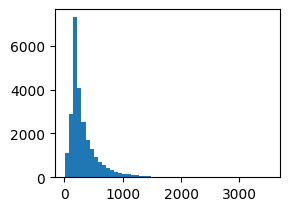

In [14]:
from matplotlib import pyplot as plt

lengths = []
for row in ds['train']:
    ids = tokenizer(row['text']).input_ids
    lengths.append(len(ids))

plt.subplot(2, 2, 2)
plt.hist(lengths, bins=50)
plt.show()

Token 개수의 평균은 다음과 같습니다.

In [15]:
sum(lengths) / len(lengths)

323.03248

## Dataloader 만들기

이번에는 주어진 dataset `ds['train'], ds['test']`를 가지고 dataloader를 구현할 것입니다.
Text data와 같은 data는 각각의 입력이 가변적이기 때문에 dataloader를 구현하는 것이 까다로워집니다.
이처럼 matrix로 예쁘게 모을 수 없는 경우를 처리하기 위해 dataloader는 `collate_fn`이라는 인자로 batch를 처리할 수 있는 함수를 직접 구현할 수 있는 옵션을 제공합니다. 여기서 batch는 입력들의 list를 의미합니다.

입력들의 list가 주어졌을 때 text들은 tokenize와 padding을 동시에 진행하여 하나의 matrix로 만드는 것은 다음과 같이 구현할 수 있습니다.

In [16]:
from torch.utils.data import DataLoader


def collate_fn(batch):
    max_len = 400
    texts, labels = [], []
    for row in batch:
        labels.append(row['label'])
        texts.append(row['text'])

    texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
    labels = torch.LongTensor(labels)

    return texts, labels

`tokenizer`의 인자로 들어가는 `truncation`과 `max_length`는 길이가 max_length를 넘는 data들은 max_length에서 자르라는 옵션입니다. 나머지는 위에서 설명한 tokenizer를 활용하는 방법과 동일합니다. Dataloader에서 원하는 collate_fn의 형태가 무엇인지 아는 것이 중요합니다.
이렇게 구현한 `collate_fn`을 가지고 dataloader를 구현한 것은 다음과 같습니다.

In [17]:
train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

다른 부분들은 이전 실습과 동일합니다. 차이는 `collate_fn`을 인자로 넘겨주는 부분입니다.

이렇게 만들어진 dataloader에서 첫 번째 batch를 출력한 결과는 다음과 같습니다.

In [18]:
text, label = next(iter(train_loader))
print(text.shape, label.shape)

torch.Size([64, 400]) torch.Size([64])


보시다시피 우리가 지정한 batch size로 잘 반환하는 것을 알 수 있습니다.
여기서 text의 shape은 (B, S)의 형태인데, 이 S의 값은 batch 안에서 가장 긴 text로 결정되기 때문에 각각의 batch마다 값이 달라질 수 있다는 점 유의하시길 바랍니다.

 ## RNN 구현

 이번에는 본격적으로 주어진 token list가 긍정적인지 부정적인지를 출력해주는 model을 구현합니다.
 이 model의 중요한 점은 세 가지입니다:

 1. Token list를 `nn.Embedding`으로 전처리해줍니다.
 2. `nn.RNN`으로 선언된 RNN을 통과시켜 representation을 얻습니다.
 3. 주어진 token list의 마지막 token에 해당하는 representation을 얻어 `nn.Linear`를 통과시켜 출력을 구합니다.


이를 구현한 것은 다음과 같습니다.

In [19]:
from torch import nn


class TextClassifier(nn.Module):
    def __init__(self, vocab_size, hidden_dim, n_layers):
        super().__init__()

        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=tokenizer.pad_token_id)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers=n_layers, nonlinearity='relu', batch_first=True)
        self.classifier = nn.Linear(hidden_dim, 1)

    def forward(self, x_org):
        x = self.embedding(x_org)
        x, _ = self.rnn(x)

        lengths = (x_org != tokenizer.pad_token_id).sum(dim=-1) - 1
        lengths = lengths[:, None, None].repeat(1, 1, self.hidden_dim)

        x = x.gather(1, lengths)
        x = x[:, 0]

        x = self.classifier(x)
        return x


model = TextClassifier(len(tokenizer), 32, 2)

위의 두 줄은 dataloader로 부터 들고온 token list의 batch를 embedding하고 RNN을 태운 결과입니다.
RNN은 입력이 (B, S, *)이면 output도 (B, S, *)이 됩니다.
각각의 token에 대한 출력 결과를 기본적으로 반환합니다.
여기서 중요한 것은 짧은 token list들은 뒷 부분이 padding token으로 채워져 있기 때문에 padding token이 등장하기 전 마지막 token의 출력 결과를 활용하여 text 분류를 진행해야 한다는 점입니다.
즉, token list의 진짜 마지막 token에 해당하는 RNN output을 사용해야 합니다.
이를 구현한 것이 `forward` 함수의 중간 부분입니다.
먼저 batch의 각 입력의 마지막 token의 위치를 길이로 계산하여 얻습니다. 그리고 이를 `.gather`를 활용하여 들고옵니다.
마지막으로 `x[:, 0]`를 호출하여 squeeze를 진행합니다.

다음은 위에서 확인한 dataloader 첫 batch를 입력으로 넣었을 때, 출력의 shape입니다.

In [20]:
model(text).shape

torch.Size([64, 1])

## 학습

마지막으로 구현한 RNN을 가지고 학습하는 코드를 구현합니다. 학습 코드는 이전 MNIST 실습과 완전히 동일하기 때문에 설명없이 결과만 확인해보도록 하겠습니다.

In [21]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCEWithLogitsLoss()

optimizer = Adam(model.parameters(), lr=lr)

In [22]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)
        # preds = torch.argmax(preds, dim=-1)
        preds = (preds > 0).long()[..., 0]

        cnt += labels.shape[0]
        acc += (labels == preds).sum().item()

    return acc / cnt

In [23]:
n_epochs = 50

for epoch in range(n_epochs):
    total_loss = 0.
    model.train()  # 모델을 학습 모드로 설정
    for data in train_loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda').float()

        preds = model(inputs)[..., 0]
        loss = loss_fn(preds, labels)
        loss.backward() # 역전파
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

    with torch.no_grad():  # 기울기 계산을 비활성화해서 메모리 사용을 줄이고 연산 속도를 높임.
        model.eval()  # 모델을 평가 모드로 설정
        train_acc = accuracy(model, train_loader)
        test_acc = accuracy(model, test_loader)
        print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 269.04829454421997
=========> Train acc: 0.580 | Test acc: 0.556
Epoch   1 | Train Loss: 255.13785415887833
=========> Train acc: 0.709 | Test acc: 0.676
Epoch   2 | Train Loss: 232.19603180885315
=========> Train acc: 0.728 | Test acc: 0.684
Epoch   3 | Train Loss: 230.04442247748375
=========> Train acc: 0.759 | Test acc: 0.708
Epoch   4 | Train Loss: 207.7567858994007
=========> Train acc: 0.767 | Test acc: 0.729
Epoch   5 | Train Loss: 203.81463387608528
=========> Train acc: 0.767 | Test acc: 0.700
Epoch   6 | Train Loss: 202.09636679291725
=========> Train acc: 0.732 | Test acc: 0.667
Epoch   7 | Train Loss: 184.74447122216225
=========> Train acc: 0.806 | Test acc: 0.773
Epoch   8 | Train Loss: 178.26086556911469
=========> Train acc: 0.810 | Test acc: 0.733
Epoch   9 | Train Loss: 187.5592381954193
=========> Train acc: 0.796 | Test acc: 0.711
Epoch  10 | Train Loss: 176.0193133354187
=========> Train acc: 0.775 | Test acc: 0.684
Epoch  11 | Train Loss: 

불안정한 부분들이 있지만, 잘 수렴하는 것을 확인할 수 있습니다. 이전 챕터에서 배운 LSTM이나 GRU는 PyTorch에서 `nn.LSTM`과 `nn.GRU`로 잘 구현되어있습니다. `nn.RNN`의 인자들을 그대로 활용할 수 있기 때문에 코드상에서 대체하여 바로 사용할 수 있습니다.